In [1]:
import os 
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cdasws import CdasWs
import cdflib
import pyspedas
from datetime import datetime, timedelta


#Constant values of proton 
mp   = 1.6726*10**-27
kB = 1.380649e-23       # Boltzmann constant (J/K)
mu0 = 4 * np.pi * 1e-7  # Permeability of free space (N/A^2)

catalog = pd.read_excel(r"Sub-Alfvenic_Solar_Winds.xlsx")
catalog['Date'] = pd.to_datetime(catalog['Date'], errors='coerce')
catalog['Time'] = catalog['Time'].astype(str).str.strip()
catalog['datetime'] = pd.to_datetime(catalog['Date'].astype(str) + ' ' + catalog['Time'].astype(str), errors='coerce')
t_start = catalog['datetime'] - pd.Timedelta(days=2)
t_end = catalog['datetime'] + pd.Timedelta(days=2)
# Create DataFrame with time ranges and save to Excel
time_ranges = pd.DataFrame({
    'Start Time': t_start,
    'End Time': t_end
})
time_ranges.to_excel(r'L1_Sub-Alfvenic.xlsx', index=False)


ACE = CdasWs()


In [2]:
catalog

,S. No.,M_A Minimum,Date,Time,Interplanetary Structure,Detecting Spacecraft,datetime
0,1,0.38,1992-11-09,19:15,MC,IMP 8,1992-11-09 19:15:00
1,2,0.90,1997-04-11,11:22,MC,Geotail,1997-04-11 11:22:00
2,3,0.82,1997-11-22,19:18,MC,Wind,1997-11-22 19:18:00
3,4,0.80,1999-04-27,04:17,HSS tail,"Wind, ACE",1999-04-27 04:17:00
4,5,0.60,1999-05-11,18:36,HSS tail,"Wind, ACE",1999-05-11 18:36:00
5,6,0.61,2000-03-29,06:37,MC,Wind,2000-03-29 06:37:00
6,7,0.67,2000-07-16,01:49,MC,"Geotail, ACE",2000-07-16 01:49:00
7,8,0.75,2000-07-16,04:49,MC,"Geotail, ACE",2000-07-16 04:49:00
8,9,0.66,2000-08-12,12:33,MC,Geotail,2000-08-12 12:33:00
9,10,0.98,2001-04-12,08:26,MC,ACE,2001-04-12 08:26:00


1999-05-09 18:36:00 to 1999-05-13 18:36:00


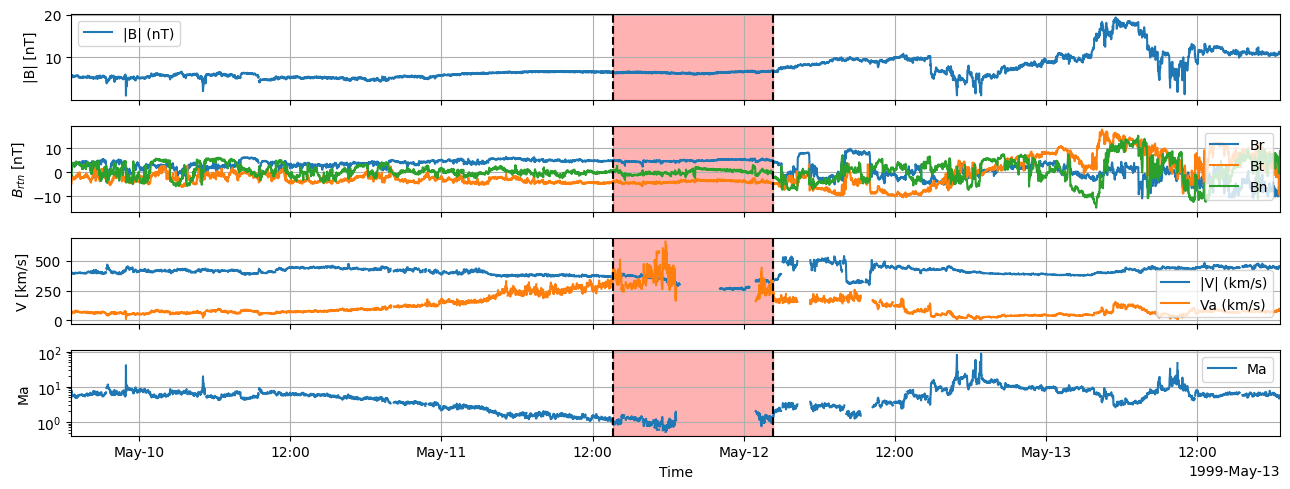

In [51]:
import numpy as np
import pandas as pd

filval = -1e29

for i in range(4, len(t_start)):
    time0, time1 = t_start[i], t_end[i]
    print(f"{time0} to {time1}")
    # --- Magnetic Field Data ---
    datasets = ['AC_H3_MFI']
    status_m, data_m = ACE.get_data(datasets, ['ALL-VARIABLES'], time0, time1)
    Mag_Time = data_m['Epoch']

    # Convert and clean quickly
    for k, v in data_m.items():
        if k == 'Epoch':
            continue
        arr = np.asarray(v)
        if np.issubdtype(arr.dtype, np.number):
            arr = arr.astype(float, copy=False)
            arr[arr <= filval] = np.nan
            data_m[k] = arr

    # --- Plasma Data ---
    datasets = ['AC_H0_SWE']
    status_p, data_p = ACE.get_data(datasets, ['ALL-VARIABLES'], time0, time1)
    Plasma_Time = data_p['Epoch']
    Plasma = {}
    for k, v in data_p.items():
        if k == 'Epoch':
            continue
        arr = np.asarray(v)
        if np.issubdtype(arr.dtype, np.number):
            arr = arr.astype(float, copy=False)
            arr[arr <= filval] = np.nan
            Plasma[k] = arr

    # --- Time Conversion ---
    t1 = pd.to_datetime(Mag_Time).to_numpy(dtype='datetime64[ns]')
    t2 = pd.to_datetime(Plasma_Time).to_numpy(dtype='datetime64[ns]')

    # --- Nearest-Neighbor Matching ---
    idx = np.searchsorted(t1, t2)
    idx = np.clip(idx, 1, len(t1) - 1)

    left, right = idx - 1, idx
    nearest_idx = np.where(
        np.abs(t1[left] - t2) < np.abs(t1[right] - t2),
        left, right
    )

    # --- Extract aligned quantities ---
    B_mag = np.array(data_m['Magnitude'])[nearest_idx]
    BRTN = np.array(data_m['BRTN'])[nearest_idx]
    V_mag = np.linalg.norm(np.array(Plasma['V_RTN']), axis=1)  # assume vector [Vr, Vt, Vn]
    Vp = np.array(Plasma['Vp'])
    Np = np.array(Plasma['Np'])
    epoch = pd.to_datetime(data_p['Epoch'])

    # --- Build DataFrame ---
    df = pd.DataFrame({
        'B_mag': B_mag,
        'BR': BRTN[:,0],
        'BT': BRTN[:,1],
        'BN': BRTN[:,2],
        'V_mag': V_mag,
        'Vp': Vp,
        'N': Np
    }, index=epoch)

    # --- Derived parameters ---
    df['Va'] = (df['B_mag'] * 1e-9) / np.sqrt(mu0 * mp * df['N'] * 1e6)  # m/s
    df['Ma'] = (df['V_mag'] * 1e3) / df['Va']

    Filter = df.index[df['Ma']<1]
    # --- Plotting ---
    fig, axs = plt.subplots(4, 1, figsize=(13, 5), sharex=True)
    axs[0].plot(df.index, df['B_mag'], label='|B| (nT)')
    axs[0].set_ylabel('|B| [nT]')

    axs[1].plot(df.index, df['BR'],label = 'Br')
    axs[1].plot(df.index, df['BT'],label = 'Bt')
    axs[1].plot(df.index, df['BN'],label = 'Bn')

    axs[1].set_ylabel('$B_{rtn}$ [nT]')


    axs[2].plot(df.index, df['V_mag'], label='|V| (km/s)')
    axs[2].plot(df.index, df['Va']/1e3, label='Va (km/s)')
    axs[2].set_ylabel('V [km/s]')

    axs[3].plot(df.index, df['Ma'], label='Ma')
    axs[3].set_ylabel('Ma')
    axs[3].set_yscale('log')
    axs[-1].set_xlabel('Time')

    for ax in axs:
        ax.legend()
        ax.grid(True)
        ax.axvline(Filter[0], ls='--', color='k')   # start
        ax.axvline(Filter[-1], ls='--', color='k')  # end

        ax.axvspan(Filter[0],Filter[-1],color ='red',alpha = 0.3)
    plt.xlim([df.index[0], df.index[-1]])
    plt.tight_layout()
    plt.show()
    break  # remove later if you want to process all windows


In [50]:
catalog

,S. No.,M_A Minimum,Date,Time,Interplanetary Structure,Detecting Spacecraft,datetime
0,1,0.38,1992-11-09,19:15,MC,IMP 8,1992-11-09 19:15:00
1,2,0.90,1997-04-11,11:22,MC,Geotail,1997-04-11 11:22:00
2,3,0.82,1997-11-22,19:18,MC,Wind,1997-11-22 19:18:00
3,4,0.80,1999-04-27,04:17,HSS tail,"Wind, ACE",1999-04-27 04:17:00
4,5,0.60,1999-05-11,18:36,HSS tail,"Wind, ACE",1999-05-11 18:36:00
5,6,0.61,2000-03-29,06:37,MC,Wind,2000-03-29 06:37:00
6,7,0.67,2000-07-16,01:49,MC,"Geotail, ACE",2000-07-16 01:49:00
7,8,0.75,2000-07-16,04:49,MC,"Geotail, ACE",2000-07-16 04:49:00
8,9,0.66,2000-08-12,12:33,MC,Geotail,2000-08-12 12:33:00
9,10,0.98,2001-04-12,08:26,MC,ACE,2001-04-12 08:26:00


In [ ]:
# Find indices where Ma < 1
low_ma = df['Ma'] < 1

# Find start and end of each contiguous interval
intervals = []
in_interval = False
for i, val in enumerate(low_ma):
    if val and not in_interval:
        start = df.index[i]
        in_interval = True
    elif not val and in_interval:
        end = df.index[i-1]
        intervals.append((start, end))
        in_interval = False

# Catch case if last point is still low
if in_interval:
    intervals.append((start, df.index[-1]))

# --- Plotting ---
fig, axs = plt.subplots(4, 1, figsize=(13, 5), sharex=True)

axs[0].plot(df.index, df['B_mag'], label='|B| (nT)')
axs[0].set_ylabel('|B| [nT]')

axs[1].plot(df.index, df['BR'], label='Br')
axs[1].plot(df.index, df['BT'], label='Bt')
axs[1].plot(df.index, df['BN'], label='Bn')
axs[1].set_ylabel('$B_{rtn}$ [nT]')

axs[2].plot(df.index, df['V_mag'], label='|V| (km/s)')
axs[2].plot(df.index, df['Va']/1e3, label='Va (km/s)')
axs[2].set_ylabel('V [km/s]')

axs[3].plot(df.index, df['Ma'], label='Ma')
axs[3].set_ylabel('Ma')
axs[3].set_yscale('log')
axs[3].set_xlabel('Time')

# Plot all intervals
for ax in axs:
    ax.legend()
    ax.grid(True)
    for start, end in intervals:
        ax.axvspan(start, end, color='red', alpha=0.3)

plt.xlim([df.index[0], df.index[-1]])
plt.tight_layout()
plt.show()


np.float64(0.919711421302777)

In [27]:
data_p.keys(
    
)

dict_keys(['Epoch', 'Np', 'Vp', 'Tpr', 'alpha_ratio', 'V_GSE', 'V_RTN', 'V_GSM', 'SC_pos_GSE', 'SC_pos_GSM', 'metavar0', 'metavar1', 'metavar2', 'metavar3', 'metavar4'])